<h1><center>Email Spam Classifier</center></h1>

This project is based on Manning's book "Transfer Learning for NLP" in chapter 2
The goal is to:
1. Curate a dataset with emails and spam consisting of random 1000 samples of each class
2. Extract from the emails only the text,i.e, no headers.
3. Create a simple bag-of-words model from the above content. Simple because it is based on term frequency (tf)
4. Choose one baseline classifier from Logistic Regression and Gradient Boosting Machine
5. Assess is the metric of choice as the dataset is balanced and consists of two classes

In [1]:
# Import requiered libraries
import pandas as pd
import numpy as np
import email
import os
import pickle

Define data file path, i.e., directory where data to train the classifier is. As this is a csv type the file is loaded with pandas read_csv function. If successfull the number of rows and columns with the first 5 rows are printed.

In [2]:
data_file_path = "/home/baosiek/Documents/deep_learning/transfer-learning/data/emails.csv"
emails = pd.read_csv(data_file_path)
print("Emails were loaded successfully containing {} rows and {} columns".format(emails.shape[0], emails.shape[1]))
print("Printing 5 first rows...")
print(emails.head(5))

Emails were loaded successfully containing 517401 rows and 2 columns
Printing 5 first rows...
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


Prints the contect of the first email, under the message column, enabling data understanding.

In [3]:
print(emails.loc[0, "message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


Lets get only the text part of the message, discarding date, from, to and Subject info. 

In [4]:
def extract_text(emails):

    # Initializes a list of texts where each row will contain only the content of the email
    contents = []
    
    for item in emails["message"]:
        e = email.message_from_string(item)
        content = e.get_payload() # Gets only a string with the email content
        contents.append(content)
        
    return contents

In [5]:
# This process may take sometime. So we first check if the emails were already
# processed with their respective content in a list. If this data is not found this 
# procedure extracts the content from the emails and stores it.
if not os.path.exists('/home/baosiek/Documents/deep_learning/transfer-learning/data/contents.txt'):
    contents = extract_text(emails)
    with open("./data/contents.txt", "wb") as fp:   # Serializing
        pickle.dump(contents, fp)
else:
    with open("./data/contents.txt", "rb") as fp:   # Deserializing
        contents = pickle.load(fp)
        

# Prints the content at row 100
print(contents[100])

I tried the new address but I don't have access.  also, what do I need to 
enter under domain?


Testing if number of rows in emails data frame and contents list data structure are equal.

In [6]:
if len(contents) == emails.shape[0]:
    print("Success!")

Success!


Converts contents list into a data frame and prints the first 5 emails contents

In [7]:
contents_df = pd.DataFrame(contents)
print(contents_df.head(n=5))

                                                   0
0                          Here is our forecast\n\n 
1  Traveling to have a business meeting takes the...
2                     test successful.  way to go!!!
3  Randy,\n\n Can you send me a schedule of the s...
4                Let's shoot for Tuesday at 11:45.  


# The Spam dataset

In [8]:
data_file_path = "/home/baosiek/Documents/deep_learning/transfer-learning/data/fradulent_emails.txt"
with open(data_file_path, 'r', encoding='latin1') as file:
    spams = file.read()
# spams is a long string beacause originally the data downloaded is a single text file.
# We need to find how to split this entire file into units where each one in a single email.
# So reading the downloaded file with Gedit we can conclude that each email starts with
# the char sequence "From r". So we will use this to split this big string into a list of emails.
# The reason why we associate to the final structure all emails from 1 and not 0 is because the 
# original file starts with 'From r' splitting it into an empty first element and the first email in
# the second elemnt of the spams list
spams = spams.split('From r')[1:]
print(f'Spams was successfully downloaded and contains {len(spams)} emails')

spams_df = extract_text(pd.DataFrame(spams, columns=['message']))
spams_df = pd.DataFrame(spams_df)
print(spams_df.head())

Spams was successfully downloaded and contains 3977 emails
                                                   0
0  FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1  Dear Friend,\n\nI am Mr. Ben Suleman a custom ...
2  FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3  FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4  Dear sir, \n \nIt is with a heart full of hope...


# Hyperparameters

Now lets create the dataset to train classifiers. It will contain n_samples from each data frame (emails and spams). Each sample will contain max_tokens and each token max_characters as hyperparameters to enable acceptable performance for training and classification.

In [9]:
n_samples = 1000 # number of samples frome each data frame
max_tokens = 50 # maximum number of tokens in each email
max_chars = 20 # maximum length of each token

Function to tokenize emails

In [10]:
def tokenize(row):
    
    if row == None or row == '' or type(row) == list:
        tokens = ""
    else:
        tokens = row.split(" ")[:max_tokens]
        
    return tokens

Function to extract punctuations, lowercase all tokens anf limit token size

In [11]:
import re

def clean_text(token_list):
    
    tokens = []
    
    try:
        for token in token_list:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)[:max_chars]
            tokens.append(token)
            
    except:
        tokens.append("")
        
    return tokens    

Build dataframe with emails and spams.

Removing stopwords

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

def stopwords_removal(token_list):
    
    token = [token for token in token_list if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/baosiek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
real_emails = contents_df.iloc[:, 0]
real_emails = real_emails.apply(tokenize)
real_emails = real_emails.apply(stopwords_removal)
real_emails = real_emails.apply(clean_text)
real_emails = real_emails.sample(n_samples)
print(f'real_emails dataframe contains {real_emails.shape[0]} samples. Listing first 5...')
print(real_emails.head(n=5))

real_emails dataframe contains 1000 samples. Listing first 5...
216064    [what, i, need, move, thing, forwardi, suspect...
70231     [we, usual, conference, call, coming, monday, ...
469077                                 [mikebroker, , mw, ]
340745    [the, allemployee, meeting, scheduled, thursda...
339310    [today, announced, appointment, jeff, mcmahon,...
Name: 0, dtype: object


In [14]:
spam_emails = spams_df.iloc[:, 0]
spam_emails = spam_emails.apply(tokenize)
spam_emails = spam_emails.apply(stopwords_removal)
spam_emails = spam_emails.apply(clean_text)
spam_emails = spam_emails.sample(n_samples)
print(f'spam_emails dataframe contains {spam_emails.shape[0]} samples. Listing first 5...')
print(spam_emails.head(n=5))

spam_emails dataframe contains 1000 samples. Listing first 5...
1871    [attnc, greetingc, i, solicit, confidence, tra...
3027    [dear, belovedi, sussan, adamsplease, endeavou...
1593    [greetings, dear, friend, please, permit, cont...
1298    [from, mrikamaratel, , , , dear, this, letter,...
2372                                                   []
Name: 0, dtype: object


Lets combine these two data frames into one NP array

In [15]:
data = pd.concat([spam_emails, real_emails], axis=0).values
print(f'data is a {type(data)}. Shape is {data.shape}.')
print(data)

data is a <class 'numpy.ndarray'>. Shape is (2000,).
[list(['attnc', 'greetingc', 'i', 'solicit', 'confidence', 'transaction', 'i', 'propose', 'youe', 'this', 'virtue', 'nature', 'utterly', 'confidentiale', 'though', 'i', 'know', 'transaction', 'magnitude', 'make', 'one', 'apprehensive', 'worried', 'i', 'assuring'])
 list(['dear', 'belovedi', 'sussan', 'adamsplease', 'endeavour', 'to', 'use', 'it', 'for', 'the', 'children', 'of', 'god', 'i', 'abovenamed', 'person', 'i', 'married', 'dr', 'donald', 'adams', 'a', 'liberian', 'iem', 'nowin', 'nigerian', 'general', 'hospital', 'taking', 'treatment', 'sickness', 'whoworked', 'us', 'embassy', 'liberian', 'nine', 'years'])
 list(['greetings', 'dear', 'friend', 'please', 'permit', 'contact', 'medium', 'i', 'barrister', 'tunji', 'bello', 'solicitor', 'atlaw', 'i', 'personal', 'attorney', 'one', 'late', 'clients', 'used', 'work', 'indigenous', 'company', 'countryin', 'summer', '', 'client', 'wife'])
 ...
 list(['attached', 'redlined', 'minutes', 

Creting labels to the emails in data. The first 1000 columsn [:1000] are real emails (label=1) and the last 1000 [1000:] are spams (label=0)

In [16]:
categories = ['spam', 'real']
labels = ([1]*n_samples) # spams
labels.extend(([0]*n_samples)) # emails

print(f'labels has shape {len(labels)}')
print(labels[:5]) # printing first 5 real labels
print(labels[1000: 1005]) # printing first spam labels

labels has shape 2000
[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


In [17]:
def bag_of_words(data):
    
    all_tokens = []
    used_tokens = []
    for row in data:
        for token in row:
            if token in all_tokens:
                if token not in used_tokens:
                    used_tokens.append(token)
            else:
                all_tokens.append(token)
                
    bow_df = pd.DataFrame(0, index=np.arange(len(data)), columns=used_tokens, dtype=int)
    
    for index, row in enumerate(data):
        for token in row:
            if token in used_tokens:
                bow_df.iloc[index][token] += 1
    
    return bow_df

bow_df = bag_of_words(data)
print(bow_df.head(n=10))

   i  transaction  liberian  dear  one     this  contact  late  the  ...  \
0  4            2         0     0    1  0     1        0     0    0  ...   
1  2            0         2     1    0  0     0        0     0    1  ...   
2  2            0         0     1    1  1     0        1     1    0  ...   
3  1            0         0     1    0  3     1        1     1    1  ...   
4  0            0         0     0    0  0     0        0     0    0  ...   
5  0            0         0     0    0  0     0        0     0    0  ...   
6  1            0         0     0    0  1     0        1     0    0  ...   
7  2            0         0     0    0  1     0        0     1    1  ...   
8  0            0         0     0    0  0     0        0     0    0  ...   
9  0            0         0     0    0  1     0        0     0    0  ...   

   cordially  invites  angel  breakfast  houstonian  lane  randy  brazil  \
0          0        0      0          0           0     0      0       0   
1          

In [18]:
predictors = [column for column in bow_df.columns]

Shuffling data

In [19]:
def shuffle_data(data_np, labels_lst):
    shuffled_index = np.random.permutation(len(labels_lst))
    data_np = data_np[shuffled_index]
    labels_np = np.asarray(labels_lst)[shuffled_index]
    return data_np, labels_np
    
data_np, labels_np = shuffle_data(bow_df.values, labels)
print(f'data shape: {data_np.shape}')
print(f'labels shape: {labels_np.shape}')

if data_np.shape[0] == labels_np.shape[0]:
    print("Sucsess!")
else:
    print("Failure!")

data shape: (2000, 4620)
labels shape: (2000,)
Sucsess!


Divide data into training and testing sets

In [20]:
idx = int(data_np.shape[0]*0.7)
train_X = data_np[:idx]
train_y = labels_np[:idx]
test_X = data_np[idx:]
test_y = labels_np[idx:]
print(f'train input shape {train_X.shape}, train labels shape {train_y.shape}')
print(f'test input shape {test_X.shape}, test labels shape {test_y.shape}')
if train_X.shape[0] + test_X.shape[0] == data.shape[0]:
    if train_y.shape[0] + test_y.shape[0] == data.shape[0]:
        print("Success. Shapes are ok!")
    else:
        print("Failure!")
else:
    print("Failure!")

train input shape (1400, 4620), train labels shape (1400,)
test input shape (600, 4620), test labels shape (600,)
Success. Shapes are ok!


# Logistic Regression Classifier

In [21]:
from sklearn.linear_model import LogisticRegression

def fit(train_X, train_y):
    
    model = LogisticRegression()
    
    try:
        model.fit(train_X, train_y)
    except:
        pass
    
    return model

In [22]:
model = fit(train_X, train_y)

In [23]:
predictions = model.predict(test_X)

In [24]:
from sklearn.metrics import accuracy_score

accuracy_score = accuracy_score(test_y, predictions)
print(f'LogisticRegression accucary is: {accuracy_score}')

LogisticRegression accucary is: 0.9416666666666667


# Gradient Boosting Machine

Considered to be the best class of methods for addressing non-perceptual ML problems.

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time

def model_fit(classifier, train_X, train_y, test_X, test_y, predictors, performCV=True, cv_folds=5):
    
    classifier.fit(train_X, train_y)
    predictions = classifier.predict(test_X)
    pred_prob = classifier.predict_proba(test_X)[:, 1]
    if performCV:
        cv_score = cross_val_score(classifier, train_X, train_y, cv=cv_folds, scoring='roc_auc')
        # area under the Receiver Operating Characteristic curve
        
    print("Model Report")
    print(f'Accuracy: {metrics.accuracy_score(test_y, predictions)}')
    print("AUC Score (Train): %f" % metrics.roc_auc_score(test_y, pred_prob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #print(classifier.feature_importances_.shape[0],len(predictors))
    feat_imp = pd.Series(classifier.feature_importances_,predictors).sort_values(ascending=False)
    feat_imp[:10].plot(kind='bar',title='Feature Importances')
    
    return classifier.predict(test_X), classifier.predict_proba(test_X)
    

Model Report
Accuracy: 0.8766666666666667
AUC Score (Train): 0.960092
CV Score : Mean - 0.9608 | Std - 0.01353325 | Min - 0.9393081 | Max - 0.9807103
Training time: 97.95776772499084


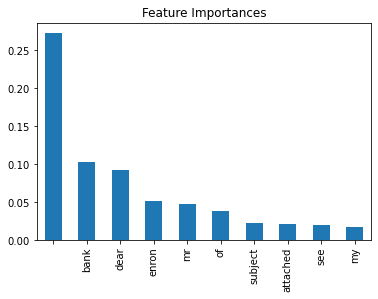

In [26]:
gbc = GradientBoostingClassifier(random_state=10)
start = time.time()
test_predictions, test_prob = model_fit(gbc, train_X, train_y, test_X, test_y, predictors)
stop = time.time()
print(f'Training time: {stop - start}')

Testing accuracy of 0.87 is lower than the mean average accuracy of the 5-fold cross validation, 0.96, which is an indication of overfitting.

# ROC Curve

In [27]:
test_prob_max = []
for i in range(test_prob.shape[0]):
    test_prob_max.append(test_prob[i, test_y[i]])
    
fpr, tpr, thresholds = metrics.roc_curve(test_y, np.array(test_prob_max))

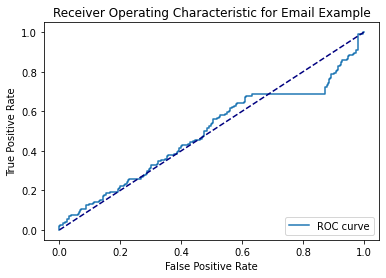

In [28]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
plt.plot(tpr,fpr,label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Email Example')
plt.legend(loc="lower right")
plt.show()

Our baseline model will be LogisticRegresiion as it's performance is satisfactory, it is fast and simple to understand.

In [37]:
print(f'Baseline model of choice: {model}, with accuray: {accuracy_score :.4f}')

Baseline model of choice: LogisticRegression(), with accuray: 0.9417


# Transfer Learning

Import all required libraries for tensorflow on CPU and keras

In [138]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model, load_model
from bert import BertModelLayer

We will be starting with a simple BERT usage

In [111]:
def convert_data(raw_data, headers):
    convert_data, labels = [], []

    for i in range(raw_data.shape[0]):
        out = ' '.join(raw_data[i])
        convert_data.append(out)
        labels.append(headers[i])

    convert_data = np.array(convert_data, dtype=object)[:, np.newaxis]

    return convert_data, np.array(labels)

raw_data, header = convert_data(data, labels)
print(raw_data[:1])

[['attnc greetingc i solicit confidence transaction i propose youe this virtue nature utterly confidentiale though i know transaction magnitude make one apprehensive worried i assuring']]


In [112]:
idx = int(0.7*raw_data.shape[0])
train_X, train_y = convert_data(raw_data[:idx], header[:idx])
test_X, test_y = convert_data(raw_data[idx:], header[idx:])

In [140]:
l_bert = BertModelLayer(**BertModelLayer.Params(
  vocab_size               = 16000,        # embedding params
  use_token_type           = True,
  use_position_embeddings  = True,
  token_type_vocab_size    = 2,

  num_layers               = 12,           # transformer encoder params
  hidden_size              = 768,
  hidden_dropout           = 0.1,
  intermediate_size        = 4*768,
  intermediate_activation  = "gelu",

  adapter_size             = None,         # see arXiv:1902.00751 (adapter-BERT)

  shared_layer             = False,        # True for ALBERT (arXiv:1909.11942)
  embedding_size           = None,         # None for BERT, wordpiece embedding size for ALBERT

  #name                     = "bert"        # any other Keras layer params
))

In [153]:
def build_model():

    max_seq_length = 128

    # The input layer
    input_words_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_words_id')

    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
    segments_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='segments_id')
    
    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                             trainable=True)

    pooled_output, sequence_output = bert_layer([input_words_ids, input_mask, segments_ids])

    model = Model(inputs=[input_words_ids, input_mask, segments_ids], outputs=[pooled_output, sequence_output])

    model.build(input_shape=(None, max_seq_length))

    model.summary

    return model

In [154]:
model = build_model()
tokenizer = bert.bert_tokenization.FullTokenizer
print(model)

In [132]:
def get_masks(tokens, max_seq_length):
    """Masks for padding"""
    if len(tokens) > max_seq_length:
        raise IndexError ('Token length more than max seq length')
    return [1]*len(tokens) + [0]*(max_seq_length - len(tokens))

In [4]:
s = 'This is a nice sentence.'
# s_tokens = tokenizer.tokenize(s)

In [3]:
%reset out

Flushing output cache (0 entries)
